In [57]:
import numpy as np
import pickle
from numpy.matlib import repmat
import matplotlib.pyplot as plt
import librosa
import csv
import math

In [4]:
train_list = list(filter(lambda x: (str(x)[-1] in ['1', '5']), range(1, 201)))
test_list = list(filter(lambda x: (str(x)[-1] not in ['1', '5']), range(1, 201)))
low_result = [22, 23, 73, 74, 76, 79, 92, 98, 133, 134, 138, 153, 154, 157, 163, 168, 169, 174, 176, 184, 193]

#### Basic functions to get bootleg scores for MIDI and sheet music.

In [3]:
def loadMidiBootlegScore(pkl_file):
    with open(pkl_file, 'rb') as f:
        d = pickle.load(f)
    bscore = d['bscore']
    miditimes = d['times']
    num_notes = np.array(d['num_notes'])
    stafflines = d['stafflines']
    return bscore, miditimes, num_notes, stafflines

In [4]:
def loadSheetBootlegScore(pkl_file):
    with open(pkl_file, 'rb') as f:
        d = pickle.load(f)
    bscore = d['bscore']
    events = d['events']
    return bscore, events

#### Get first or last elements of lines. 

In [5]:
def getBoundaryElements(piece, loc):
    '''
    Variable loc could be either 'F' or 'L'.
    Get all elements that are first or last element of a single line, given a piece number.
    '''
    first = []
    last = []
    with open('/home/mshan/ttemp/data/bscore_sheet/p{}.pkl'.format(piece), 'rb') as f:
        d = pickle.load(f)
        for i in range(1, len(d['events'])):
            
            # check if on the same page as the previous event
            if d['events'][i][2] != d['events'][i-1][2]:
                first.append(i)
                
        for i in range(0, len(d['events'])-1):
            # check if on the same page as the next event
            if d['events'][i][2] != d['events'][i+1][2]:
                last.append(i)
                
    if loc == 'F':
        return [0] + first # 0 is also a first element
    return last + [len(d['events']) - 1] # add the last element of a piece

#### Metric functions taken from previous code

In [6]:
def normalizedCostMetric(Q, R, numQueryNotes, numRefNotes):
    '''
    Take two vectors, return the normalized cost metric by taking dot product and divided by the maximum norm factor.
    '''
    cost = - Q.T @ R
    query_norm_factor = repmat(numQueryNotes.reshape((-1,1)), 1, R.shape[1])
    ref_norm_factor = repmat(numRefNotes.reshape((1,-1)), Q.shape[1], 1)
    norm_factor = np.maximum(query_norm_factor, ref_norm_factor) + 1e-8 # avoid divide by 0
    norm_cost = cost / norm_factor
    return norm_cost

In [7]:
def computeCostMatrix(query, ref, numRefNotes):
    numQueryNotes = np.sum(query, axis=0)
    C = normalizedCostMetric(query, ref, numQueryNotes, numRefNotes)
    return C

#### Experiment

In [8]:
piece = 5
midi_pkl_dir = '/home/mshan/ttemp/data/bscore/p5.pkl'
sheet_pkl_dir = '/home/mshan/ttemp/data/bscore_sheet/p5.pkl'

In [9]:
bscore_midi, miditimes, num_midi_notes, stafflines = loadMidiBootlegScore(midi_pkl_dir)
bscore_sheet,events = loadSheetBootlegScore(sheet_pkl_dir)
num_sheet_notes = np.asarray([len(event[0]) for event in events])

#### Run subsequence DTW for each line of music and the whole midi bootleg score. Concatenate and get matrix C. 

In [10]:
steps = np.array([2, 1, 1, 2, 1, 1]).reshape((3,2))
weights = [2,1,1]

In [11]:
bscore_midi.shape

(62, 1159)

In [12]:
bscore_sheet.shape

(62, 2746)

In [13]:
def subsequenceDTW(C, steps, weights):
    '''
    Regular subsequence DTW, used to retrieve single line of sheet music from the whole midi.
    Function taken from class homework. 
    '''

    D = np.zeros(C.shape)
    B = np.zeros(C.shape, dtype=np.int16)

    D[0, :] = C[0, :]
    for r in range(1, C.shape[0]):
        for c in range(0, C.shape[1]):
            min_cost = np.inf
            min_idx = -1
            for idx in range(len(steps)):
                r_step, c_step = steps[idx]
                if r >= r_step and c >= c_step:
                    cost = D[(r-r_step, c-c_step)] + C[(r, c)] * weights[idx]
                    if cost < min_cost:
                        min_idx = idx
                        min_cost = cost
            D[(r, c)] = min_cost
            B[(r, c)] = min_idx
            
    lastloc = (D.shape[0] - 1, np.argmin(D[-1, :]))
    path = backtrace(D, B, steps, lastloc)    
    path = np.array(path)
    
    return path, D, B

In [14]:
def backtrace(D, B, steps, lastloc):
    '''
    Regular backtrace. 
    '''

    loc = lastloc
    while loc[0] != 0:
        r, c = loc
        idx = B[(r, c)]
        r_step, c_step = steps[idx]
        loc = (r - r_step, c - c_step)
    
    return loc[1]

In [15]:
def lineDTW(piece, data='data'):
    midi_pkl_dir = '/home/mshan/ttemp/{}/bscore/p{}.pkl'.format(data, piece)
    sheet_pkl_dir = '/home/mshan/ttemp/{}/bscore_sheet/p{}.pkl'.format(data, piece)
    bscore_midi, miditimes, num_midi_notes, stafflines = loadMidiBootlegScore(midi_pkl_dir)
    bscore_sheet, events = loadSheetBootlegScore(sheet_pkl_dir)
    num_sheet_notes = np.asarray([len(event[0]) for event in events])
    
    num_lines = len(getBoundaryElements(piece, "F"))
    # C is the matrix of all last lines
    C = np.zeros((num_lines, bscore_midi.shape[1]))  # leave space to insert filler columns
    T = np.zeros((num_lines, bscore_midi.shape[1]), dtype=np.int16)  

    start_indices = getBoundaryElements(piece, "F")
    end_indices = getBoundaryElements(piece, "L")
    for line in range(num_lines):
        # calculate start and end indices for that line
        if line % 10 == 0:
            print('DTW for line {}'.format(line)) 
        start_idx = start_indices[line]
        end_idx = end_indices[line]
        bscore_line = bscore_sheet[:, start_idx : end_idx + 1]
    
        # dtw
        cost = computeCostMatrix(bscore_line, bscore_midi, num_midi_notes)
        wp, D, B = subsequenceDTW(cost, steps, weights)
    
        # update C
        C[line, :] = D[-1, :]
    
        # update T
        for col in range(T.shape[1]):
            # T[(line, col)] is the starting point for C[(line, col)].
            lastloc = (D.shape[0] - 1, col) 
            T[(line, col)] = backtrace(D, B, steps, lastloc)
    return C, T, miditimes, events

In [16]:
C, T, _, _ = lineDTW(1)

DTW for line 0
DTW for line 10
DTW for line 20
DTW for line 30
DTW for line 40
DTW for line 50
DTW for line 60
DTW for line 70


In [17]:
C.shape

(75, 1204)

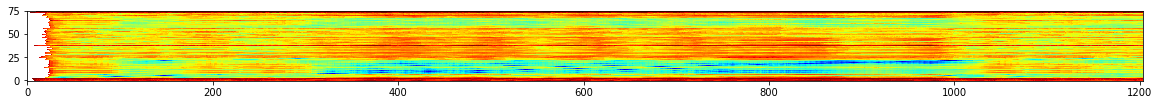

In [18]:
plt.figure(figsize = (20,20))
plt.imshow(C, origin = 'lower', cmap = 'jet')

In [19]:
T.shape
# why some negative values? 
# Doesn't matter, just ignore here.
# T[T < 0] = 0

(75, 1204)

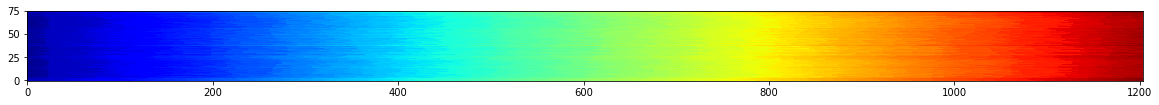

In [20]:
plt.figure(figsize = (20,20))
plt.imshow(T, origin = 'lower', cmap = 'jet')

#### hierarchicalDTW

In [16]:
def backtrace2(DD, PR, PC):
    '''
    Take the accumulated cost matrix D, and two helper matrices 
    that record the previous row and column that lead to each location in D.
    '''
    path = []
    lastrow = np.argmin(DD[:, -1])
    loc = (lastrow, DD.shape[1] - 1)
    path.append(loc)
    while loc[1] != 0:
        r, c = loc
        rprev = PR[r,c]
        cprev = PC[r,c]
        loc = (rprev, cprev)
        path.append(loc)
    return path

In [17]:
def hierarchicalDTW(C, T, alpha=.5):

    # Name them DD and BB to avoid confusion
    DD = np.zeros(C.shape)
    PR = np.zeros(C.shape, dtype=np.int16)  # previous row
    PC = np.zeros(C.shape, dtype=np.int16)  # previous column
    R_lower = np.zeros(C.shape, dtype=np.int16)
    R_upper = np.zeros(C.shape, dtype=np.int16) 
    R_lower[:,0] = np.arange(DD.shape[0]) # lower range
    R_upper[:,0] = np.arange(DD.shape[0]) # upper range (inclusive)


    for c in range(1, DD.shape[1]):
        for r in range(DD.shape[0]):
            k = T[(r, c)]

            # initialize with skip, replace if a better transition is found
            DD[r,c] = DD[r,c-1]
            PR[r,c] = r
            PC[r,c] = c-1
            R_lower[r,c] = R_lower[r,c-1]
            R_upper[r,c] = R_upper[r,c-1]
        
            if k == 0: # skip or first line
                if C[r,c] < DD[r,c]:
                    DD[r,c] = C[r,c]
                    PR[r,c] = r
                    PC[r,c] = 0
                    R_lower[r,c] = R_lower[r,0]
                    R_upper[r,c] = R_upper[r,0]

            elif k < 0: # skip only
                pass
            else: # skip or transition
                for rprev in range(DD.shape[0]):
                    if R_lower[rprev,k-1] <= r <= R_upper[rprev,k-1] + 1:
                        cprev = k-1
                        if DD[rprev,cprev] == 0:
                            weight = 1 # first line
                        else:
                            weight = 1 if rprev == r-1 else alpha
                        scr = DD[rprev,cprev] + weight * C[r,c]
                        
                        if scr < DD[r,c]:
                            DD[r,c] = scr
                            PR[r,c] = rprev
                            PC[r,c] = cprev
                            R_lower[r,c] = R_lower[rprev,k-1]
                            R_upper[r,c] = max(R_upper[rprev,k-1], r)


                            
    wp = backtrace2(DD, PR, PC)
    wp = wp[::-1]
    return wp, DD

In [ ]:
wp, DD = hierarchicalDTW(C, T)

In [115]:
with open ('/home/mshan/ttemp/data/hyp/hierarchicalDTW/{}/{}/p{}.pkl'.format('data', 0, 121), 'rb') as f:
    d = pickle.load(f)

In [116]:
wp = d['wp']

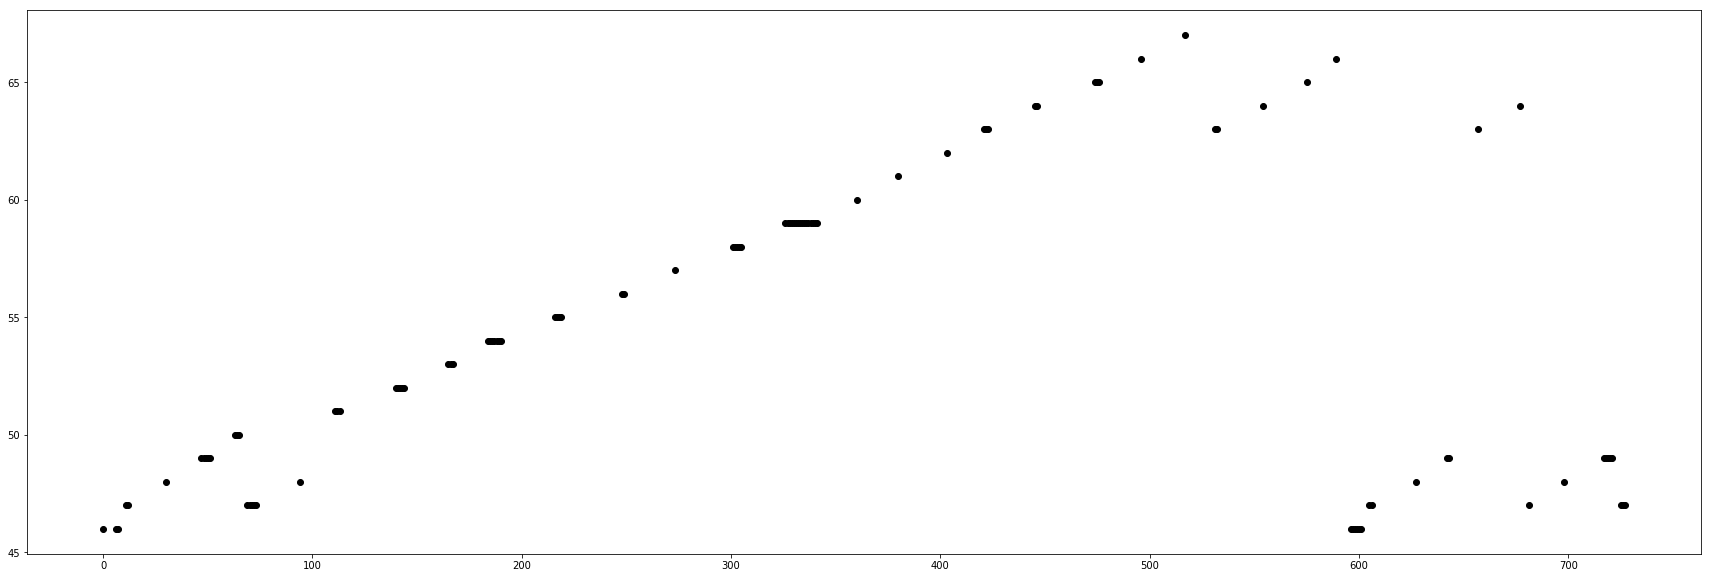

In [117]:
plt.figure(figsize = (30,10))
#plt.imshow(DD, origin = 'lower', cmap = 'jet')
plt.scatter(wp[:,1], wp[:,0], color = 'k')

### Process all queries

In [44]:
for data in ['data', 'data_repeat1', 'data_repeat2', 'data_repeat3', 'data_dsalfine']:
    for i in train_list:
        C, T, miditimes, events = lineDTW(i, data=data)
        d = {}
        d['C'] = C
        d['T'] = T
        d['miditimes'] = miditimes
        d['events'] = events
        with open('/home/mshan/ttemp/data/hyp/hierarchicalDTW/{}/p{}_temp.pkl'.format(data, i), 'wb') as f:
            pickle.dump(d, f)

DTW for line 0
DTW for line 10
DTW for line 20
DTW for line 30
DTW for line 40
DTW for line 50
DTW for line 60
DTW for line 70
DTW for line 0
DTW for line 10
DTW for line 20
DTW for line 30
DTW for line 40
DTW for line 50
DTW for line 60
DTW for line 70
DTW for line 80
DTW for line 0
DTW for line 10
DTW for line 20
DTW for line 30
DTW for line 40
DTW for line 50
DTW for line 60
DTW for line 70
DTW for line 80
DTW for line 90
DTW for line 100
DTW for line 110
DTW for line 120
DTW for line 130
DTW for line 140
DTW for line 150
DTW for line 160
DTW for line 0
DTW for line 10
DTW for line 20
DTW for line 30
DTW for line 40
DTW for line 50
DTW for line 60
DTW for line 70
DTW for line 80
DTW for line 0
DTW for line 10
DTW for line 20
DTW for line 30
DTW for line 40
DTW for line 50
DTW for line 60
DTW for line 70
DTW for line 80
DTW for line 90
DTW for line 100
DTW for line 110
DTW for line 0
DTW for line 10
DTW for line 20
DTW for line 30
DTW for line 40
DTW for line 50
DTW for line 60
DTW f

DTW for line 80
DTW for line 0
DTW for line 10
DTW for line 20
DTW for line 30
DTW for line 40
DTW for line 50
DTW for line 60
DTW for line 70
DTW for line 80
DTW for line 90
DTW for line 100
DTW for line 110
DTW for line 120
DTW for line 130
DTW for line 140
DTW for line 150
DTW for line 160
DTW for line 0
DTW for line 10
DTW for line 20
DTW for line 30
DTW for line 40
DTW for line 50
DTW for line 60
DTW for line 70
DTW for line 80
DTW for line 0
DTW for line 10
DTW for line 20
DTW for line 30
DTW for line 40
DTW for line 50
DTW for line 60
DTW for line 70
DTW for line 80
DTW for line 90
DTW for line 100
DTW for line 110
DTW for line 0
DTW for line 10
DTW for line 20
DTW for line 30
DTW for line 40
DTW for line 50
DTW for line 60
DTW for line 70
DTW for line 80
DTW for line 90
DTW for line 0
DTW for line 10
DTW for line 20
DTW for line 30
DTW for line 40
DTW for line 50
DTW for line 60
DTW for line 70
DTW for line 80
DTW for line 90
DTW for line 100
DTW for line 110
DTW for line 0
DTW

In [26]:
def align(piece, data='data', alpha=0):
    filename = '/home/mshan/ttemp/data/hyp/hierarchicalDTW/{}/{}/p{}.pkl'.format(data, alpha, piece)
    if path.exists(filename):
        print(filename + "already exists!")
        return
    with open('/home/mshan/ttemp/data/hyp/hierarchicalDTW/{}/p{}_temp.pkl'.format(data, piece), 'rb') as f:
        d = pickle.load(f)
        C = d['C']
        T = d['T']
        miditimes = d['miditimes']
        events = d['events']
    wp, _ = hierarchicalDTW(C, T, alpha=alpha)
    wp = np.asarray(wp)
    times = [miditime[0] for miditime in miditimes]
    midi_frame = [time_point[1] for time_point in wp]
    actual_time = [times[k] for k in midi_frame]
    pred_lines = [s[0] for s in wp][1:]
    time_segs = []
    for i in range(len(actual_time)):
        if i != 0:
            time_segs.append((actual_time[i-1], actual_time[i]))
            
    d = {}
    d['wp'] = wp
    d['actual_time'] = actual_time
    d['events'] = events
    d['pred_lines'] = pred_lines
    d['time_segs'] = time_segs
    with open(filename, 'wb') as f:
        print(filename)
        pickle.dump(d, f)

In [1]:
def segment(piece, data='data', alpha=0):
    filename = '/home/mshan/ttemp/data/hyp/hierarchicalDTW/{}/{}/p{}.pkl'.format(data, alpha, piece)
    with open(filename, 'rb') as f:
        d = pickle.load(f)
        times = np.arange(start=0, stop=d['actual_time'][-1], step=0.1)
        pred_lines = []
        for time_point in times:
            idx = np.where(time_point < d['actual_time'])[0][0]
            pred_lines.append(d['pred_lines'][idx-1])

    d['actual_time'] = times
    d['pred_lines'] = pred_lines
    d['time_segs'] = None
    with open(filename, 'wb') as f:
        print(filename)
        pickle.dump(d, f)

In [27]:
import multiprocessing
from os import path
for data in ['data_repeat1', 'data_repeat2', 'data_repeat3', 'data_dsalfine']:
    for alpha in [1, .5, .2, .1, .01, 0, -0.01, -0.1, -0.2]:
        for piece in train_list:
            p = multiprocessing.Process(target=align, args=(piece, data, alpha,))
            p.start()
            #align(piece, data=data, alpha=alpha)

/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/1/p5.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/1/p11.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/1/p15.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/1/p21.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/1/p25.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/1/p31.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/1/p1.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/1/p35.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/1/p41.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/1/p45.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/1/p51.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/1/p55.pklalready exists!
/home/mshan/ttemp/data/hyp/hie

/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0.2/p95.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0.2/p105.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0.2/p111.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0.2/p115.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0.2/p121.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0.2/p125.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0.2/p131.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0.2/p145.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0.2/p141.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0.2/p151.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0.2/p135.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0.2/p155.pklalready e

/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0.01/p191.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0.01/p195.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0/p1.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0/p5.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0/p11.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0/p15.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0/p21.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0/p25.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0/p31.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0/p35.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0/p41.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/0/p45.pklalready exists!
/home/mshan/ttemp/data

/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/-0.1/p85.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/-0.1/p91.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/-0.1/p95.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/-0.1/p105.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/-0.1/p101.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/-0.1/p111.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/-0.1/p115.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/-0.1/p121.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/-0.1/p125.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/-0.1/p131.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/-0.1/p135.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat1/-0.1/p141.pk

/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/1/p181.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/1/p185.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/1/p191.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/1/p195.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.5/p1.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.5/p5.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.5/p11.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.5/p15.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.5/p21.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.5/p25.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.5/p31.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.5/p35.pklalready exists!
/home/msha

/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.1/p75.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.1/p81.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.1/p85.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.1/p91.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.1/p95.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.1/p101.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.1/p105.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.1/p111.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.1/p115.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.1/p121.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.1/p125.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0.1/p131.pklalready exist

/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0/p165.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0/p175.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0/p181.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0/p185.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0/p191.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/0/p195.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/-0.01/p1.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/-0.01/p5.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/-0.01/p11.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/-0.01/p15.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/-0.01/p21.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/-0.01/p31.pklalready exists!


/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/-0.2/p55.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/-0.2/p61.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/-0.2/p65.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/-0.2/p71.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/-0.2/p75.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/-0.2/p81.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/-0.2/p85.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/-0.2/p91.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/-0.2/p95.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/-0.2/p101.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/-0.2/p105.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat2/-0.2/p111.pklalrea

/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.5/p155.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.5/p141.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.5/p161.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.5/p165.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.5/p171.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.5/p175.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.5/p191.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.5/p181.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.5/p185.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.2/p1.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.5/p195.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.2/p5.pklalready exis

/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.01/p45.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.01/p51.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.01/p55.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.01/p61.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.01/p65.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.01/p75.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.01/p71.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.01/p81.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.01/p85.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.01/p95.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.01/p101.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/0.01/p91.pklalready

/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/-0.01/p141.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/-0.01/p145.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/-0.01/p151.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/-0.01/p161.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/-0.01/p155.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/-0.01/p165.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/-0.01/p171.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/-0.01/p175.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/-0.01/p181.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/-0.01/p185.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat3/-0.01/p191.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_repeat

/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/1/p25.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/1/p31.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/1/p35.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/1/p41.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/1/p45.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/1/p51.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/1/p55.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/1/p61.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/1/p65.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/1/p71.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/1/p75.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/1/p81.pklalready exists!
/home/mshan/ttem

/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0.2/p115.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0.2/p121.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0.2/p125.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0.2/p131.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0.2/p135.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0.2/p141.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0.2/p145.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0.2/p151.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0.2/p155.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0.2/p161.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0.2/p175.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0.2/p165

/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0/p1.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0/p5.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0/p11.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0/p15.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0/p21.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0/p25.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0/p31.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0/p35.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0/p45.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0/p41.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0/p55.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/0/p51.pklalready exists!
/home/mshan/ttemp/

/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/-0.1/p85.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/-0.1/p95.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/-0.1/p91.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/-0.1/p105.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/-0.1/p101.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/-0.1/p111.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/-0.1/p115.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/-0.1/p121.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/-0.1/p125.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/-0.1/p131.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/-0.1/p135.pklalready exists!
/home/mshan/ttemp/data/hyp/hierarchicalDTW/data_dsalfine/